# Week 04 Assignment weather data

Welcome to week four of this course programming 1. You will to organise your data into the required format and apply smoothing. In this assignment we will work with weatherdata from the KNMI. A subset of weatherdata is for you available in the file: `KNMI_20181231.csv`. The data consist of several stations with daily weather data of several years. Your task is to make a plot similar to the plot below.


<img src="images/weather.png" alt="drawing" width="400"/>


Furthermore the plot needs the following enhancements

1. proper titles and ticks
2. a slider widget selecting a particular year or all years
3. lines need to be smoothed
3. legends needs to be added

Use your creativity. Consider colors, alpha settings, sizes etc. 

Learning outcomes

- load, inspect and clean a dataset 
- reformat dataframes
- apply smoothing technologies
- visualize timeseries data

The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: clean the data](#1)
- [part 3: reformat data](#2)
- [part 4: smooth the data](#3)
- [part 5: visualize the data](#4)
- [part 6: Challenge](#5)

Part 1 and 5 are mandatory, part 6 is optional (bonus)
To pass the assingnment you need to a score of 60%. 


---

<a name='0'></a>
## Part 1: Load the data

Either load the dataset `KNMI_20181231.csv` or `KNMI_20181231.txt.tsv`. The dataheaders contain spaces and are not very self explainable. Change this into more readable ones. Select data from station 270. Select only the mean, minimum and maximum temperature. The data should look something like this:


In [9]:
import pandas as pd
from pathlib import Path
import yaml
# The datafile columns consist of multiple types. Therefore, I read all types in as a string, remove everything that
# needs to be removed and than change the types back to what they should be.
def get_config():
    with open("config.yaml","r") as stream:
        config = yaml.safe_load(stream)
    return config

config = get_config()
data_dir = config["datadir"]

data = pd.read_csv(Path(data_dir + "KNMI_20181231.txt.tsv"), skiprows=63, header=0, dtype=str)

In [10]:
# data.tail()
data = data.rename(columns=lambda x: x.strip())
# print(data.columns)
data = data.rename(columns={'# STN': 'Station', 'YYYYMMDD': 'Date', 'TG':'Tmean','TN': 'Tmin','TX':'Tmax'})
data = data.iloc[1: , :]
data = data.drop(columns=['SQ', 'DR','RH'])
# print(data.dtypes)
data.Station = data.Station.astype("int64")
# print(data.dtypes)
print(data)
data_270 = data[data.Station == 270]

        Station      Date  Tmean   Tmin   Tmax
1           209  20010130                     
2           209  20010131                     
3           209  20010201                     
4           209  20010202                     
5           209  20010203                     
...         ...       ...    ...    ...    ...
331312      391  20181227     12    -18     47
331313      391  20181228      7    -29     30
331314      391  20181229     59     25     92
331315      391  20181230     78     52     87
331316      391  20181231     89     74     97

[331316 rows x 5 columns]


In [11]:
print(data_270)

        Station      Date  Tmean   Tmin   Tmax
97642       270  20000101     42     -4     79
97643       270  20000102     55     33     74
97644       270  20000103     74     49     89
97645       270  20000104     46     22     75
97646       270  20000105     41     14     56
...         ...       ...    ...    ...    ...
104577      270  20181227     57     53     62
104578      270  20181228     71     58     81
104579      270  20181229     85     69    102
104580      270  20181230     80     68     90
104581      270  20181231     87     82     97

[6940 rows x 5 columns]


---

<a name='1'></a>
## Part 2: Clean the data

The data ia not clean. There are empty cells in the dataframe which needs to be replaced with NaN's and the temperature is in centidegrees which needs to be transformed into degrees. The date field needs a datetime format. For visualization convience we would like to remove the leap year. Conduct the cleaning.

In [12]:
import numpy as np
#replace cells with spaces to NaN and change type to numeric
to_numeric = lambda x: pd.to_numeric(x, errors="coerce")

data.Tmean = to_numeric(data.Tmean)
data.Tmin = to_numeric(data.Tmin)
data.Tmax = to_numeric(data.Tmax)
# #change data format of Date to datetime64[ns]
data.Date = data.Date.astype("datetime64[ns]")
# #change temperatures to celcius degrees using a lambda function
change_temp = lambda x: x/10
data.Tmean = change_temp(data.Tmean)
data.Tmin = change_temp(data.Tmin)
data.Tmax = change_temp(data.Tmax)
#Remove leap year by using the datatime package. 
#All instances of the 29th day of the second month will be removed
data = data[~((data.Date.dt.month == 2) & (data.Date.dt.day == 29))]

In [5]:
# pd.DataFrame(data[data.Date.dt.year == 2015].groupby("Date"))

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')</li>
    <li>regex for empty cells = `^\s*$` </li>
    <li>remove month == 2 & day == 29</li> 
</ul>
</details>

In [13]:
#Test your outcome
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331078 entries, 1 to 331316
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Station  331078 non-null  int64         
 1   Date     331078 non-null  datetime64[ns]
 2   Tmean    237394 non-null  float64       
 3   Tmin     237395 non-null  float64       
 4   Tmax     237395 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 15.2 MB


### Expected outcome

---

<a name='2'></a>
## Part 3: Reform your data

First we will split the data in data from 2018 and data before 2018. Best is to split this in two dataframes. 
Next we need for the non 2018 data the minimum values for each day and the maximum values for each day. So we look for the minimum value out of all january-01 minimum values (regardless the year). Create a dataframe with 365 days containing the ultimate minimum and the ultimate maximum per day. 


In [14]:
def month_day(df_multipleyears, alternative="absolute"):
    #your code to reform data here
    df_multipleyears["day"] = df_multipleyears.Date.dt.day
    df_multipleyears["month"] = df_multipleyears.Date.dt.month
    if alternative == "absolute":
        df_multipleyears = df_multipleyears.groupby(by=[df_multipleyears.month, 
                                                        df_multipleyears.day]).agg({'Tmin':'min', 'Tmax':'max'}).reset_index()
    else:
        df_multipleyears = df_multipleyears.groupby(by=[df_multipleyears.month, 
                                                        df_multipleyears.day]).agg({"Tmean":"mean"}).reset_index()
       
    df_multipleyears =df_multipleyears.set_index(["month","day"])
    return df_multipleyears



In [8]:
# # print(y)
# # df1 = y.groupby('Date').agg({'Tmin':'min', 'Tmax':'max'})[['Tmin','Tmax']].reset_index()
# # per month and date, find the min and max temperature. Regardless of year.

# y["day"] = y.Date.dt.day
# y["month"] = y.Date.dt.month

# # df1 = y.groupby(by=[y.Date.dt.day, y.Date.dt.month]).agg({'Tmin':'min', 'Tmax':'max'}).reset_index(drop=True)

# df1 = y.groupby(by=[y.month, y.day]).agg({'Tmin':'min', 'Tmax':'max'}).reset_index()
# # print(y.groupby(y.Date.dt.day))

# # df2 = x.groupby('Date').agg({'Tmin':'min', 'Tmax':'max'})[['Tmin','Tmax']].reset_index()
# df1 = df1.set_index(["month","day"])
# print(df1)
# print(y)

In [15]:
#Test your code
def test_reformed(df):
    df = data[(data.Date.dt.year > 2007) & (data.Date.dt.year < 2018)]
    df2 = data[(data.Date.dt.year == 2018)]
    reformed_data = month_day(df)
    df2 = month_day(df2, alternative="else")
    return reformed_data, df2

reformed_data, data2018 = test_reformed(data)

C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_10820/3978815234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multipleyears["day"] = df_multipleyears.Date.dt.day
C:\Users\Public\Documents\Wondershare\CreatorTemp/ipykernel_10820/3978815234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multipleyears["month"] = df_multipleyears.Date.dt.month


In [16]:
print(reformed_data)

           Tmin  Tmax
month day            
1     1   -10.1  14.1
      2   -11.4  11.2
      3   -14.6  13.2
      4   -15.6  10.8
      5   -10.0  11.0
...         ...   ...
12    27   -5.4  13.9
      28   -9.1  13.3
      29  -10.9  13.2
      30  -11.4  13.0
      31  -12.5  14.5

[365 rows x 2 columns]


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use the dt.month and dt.day to groupby</li>
</ul>
</details>

### Expected outcome
Note, the layout or names my differ, but the length should be 365 and the minimum values should be the same

---

<a name='3'></a>
## Part 4: Smooth the data

Make a function that takes an array or a dataframe column and returns an array of smoothed data. Explain in words why you choose a certain smoothing algoritm


In [17]:
#your code here
from scipy import signal
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
def smooth_data(array, decay):
    """
    Calculates the centered moving avarage of an array, provided a number of days used to determine the mean.
    """
#     return array.rolling(window=days).mean()
    return array.ewm(com=decay).mean()

#your motivation here
##Rolling average
#The goal of smoothing is to denoise the data.Since the future values are known, the centered moving avarage can be used. 
# Because it looks at future values, events such as a change in season can be compensated for. Calculating the rolling average
# every three weeks makes sure that each month is looked at by itself, and by either the month before or after it.

##Exponential Weighted Mean
# In the weighted mean the "weights"/influence of the past temperatures decrease over time. A com parameter is set, which 
# determines the decay in center of the mass. This basically means the speed by which past values become less important. This
# value can be given as a argument, but I chose to use a value of 0.4. This means that past values decrease in weight fairly quickly
# I chose this value because the seaons influence the temperature, but there is still a period of transition between the temperatures.

In [18]:
import calendar
# Update the index to be the desired display format for x-axis
reformed_data["minmean"] = smooth_data(reformed_data.Tmin, decay=0.4)
reformed_data["maxmean"] = smooth_data(reformed_data.Tmax, decay=0.4)
reformed_data["meantemp"] = data2018.Tmean
reformed_data.index = reformed_data.index.map(lambda x: f'{calendar.month_abbr[x[0]]}')

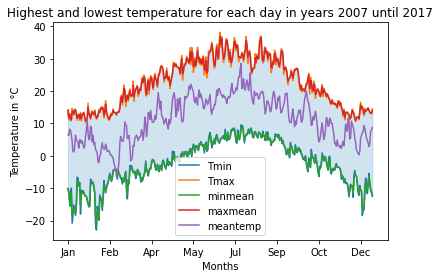

In [19]:
#I found a way to achieve the same thing using matplotlib, instead of bokeh. An advantage of this is that I was
#able to easily change the x-labels to contain the months, rather than day numbers. Something I was not able
#to do using bokeh. A disadvantage is obiously that I cannot make it interactive. Do you have any tips on how
#to achieve the same thing in bokeh?
newplot = reformed_data.plot()
newplot.set_title("Highest and lowest temperature for each day in years 2007 until 2017")
newplot.set_ylabel("Temperature in °C")
newplot.set_xlabel("Months")
newplot.fill_between(range(len(reformed_data)), reformed_data.Tmin, reformed_data.Tmax,
                 color='C0', alpha=0.2)

---

<a name='4'></a>
## Part 5: Visualize the data

Plot the mean temperature of the year 2018. Create a shaded band with the ultimate minimum values and the ultimate maximum values from the multi-year dataset. Add labels, titles and legends. Use proper ranges. Be creative to make the plot attractive. 



<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use from bokeh.models import Band</li>
    <li>use ColumnDataSource to parse data arrays</li>
    <li>look for xaxis tick formatters</li>
</ul>
</details>

In [20]:
# newplot = reformed_data.plot()
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Band
output_notebook()
# newplot.set_title("Highest and lowest temperature for each day in years 2007 until 2017")
# newplot.set_ylabel("Temperature in °C")
# newplot.set_xlabel("Months")
# reformed_data.reset_index()
print(reformed_data)
source = ColumnDataSource(reformed_data.reset_index())
p = figure(width=700, height=700, title="Minimum and Maximum temperature per day of 2007-2018 and the mean of 2018",
           x_axis_label="Days starting at January 1st", y_axis_label="Temperature in °C")
p.line(np.linspace(1, len(reformed_data) + 1, len(reformed_data)), reformed_data.Tmin, color="red", legend_label="Maximum °C 2007-2018")
p.line(np.linspace(1, len(reformed_data) + 1, len(reformed_data)), reformed_data.Tmax, color="blue", legend_label="Minimum °C 2007-2018")
p.line(np.linspace(1, len(reformed_data) + 1, len(reformed_data)), reformed_data.meantemp, color="green", legend_label="Mean °C 2018")
band = Band(base='level_0', lower='Tmin', upper='Tmax', source=source, level='underlay',
            fill_alpha=0.2, line_alpha=0.2, line_width=1, line_color='white', fill_color='grey')
p.add_layout(band)

show(p)


Loading BokehJS ...

     Tmin  Tmax    minmean    maxmean  meantemp
Jan -10.1  14.1 -10.100000  14.100000  6.523529
Jan -11.4  11.2 -11.111111  11.844444  6.300000
Jan -14.6  13.2 -13.662687  12.835821  8.208824
Jan -15.6  10.8 -15.055765  11.371908  7.864706
Jan -10.0  11.0 -11.437615  11.105753  6.508824
..    ...   ...        ...        ...       ...
Dec  -5.4  13.9  -6.373971  14.134720  2.882353
Dec  -9.1  13.3  -8.321135  13.538491  3.761765
Dec -10.9  13.2 -10.163181  13.296712  7.605882
Dec -11.4  13.0 -11.046623  13.084775  8.005882
Dec -12.5  14.5 -12.084749  14.095650  8.717647

[365 rows x 5 columns]


---

<a name='5'></a>
## Part 6: Challenge

Make a widget in which you can select the year range for the multiyear set. Add this to your layout to make the plot interactive. Add another widget to select or deselect the smoother. Inspiration: https://demo.bokeh.org/weather